In [ ]:
!pip install torch
!pip install datasets
!pip install tensorflow
!pip install numpy
!pip install keras
!pip install sklearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error

In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
from datasets import Dataset, load_dataset
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import (BertTokenizer, BertModel,AutoTokenizer, pipeline, AutoModelForSequenceClassification, TrainingArguments,
                          Trainer, DataCollatorWithPadding)
from sklearn.metrics import (accuracy_score, recall_score, precision_score, log_loss, roc_auc_score,
                             roc_curve, precision_recall_curve)
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils import to_categorical
from keras.metrics import Precision, Recall, AUC
from keras.layers import LSTM, Dense, Embedding, Conv1D, GlobalMaxPooling1D, SpatialDropout1D, TextVectorization

In [ ]:
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

id2label = {0: "benign", 1: "phishing"}
label2id = {"benign": 0, "phishing": 1}

data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

distilbert = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def import_data(type):
  return load_dataset("ealvaradob/phishing-dataset", type, trust_remote_code=True)['train'].to_pandas()

In [ ]:
def split_dataset(df):
  return train_test_split(
    df['text'],
    df['label'],
    stratify=df['label'],
    test_size=0.2,
    random_state=42
  )

In [ ]:
texts = import_data("texts")
urls = import_data("urls")
webs = import_data("webs")
combined = import_data("combined_reduced")
urls, _ = train_test_split(urls, test_size=0.95, stratify=urls['label'], random_state=42)


README.md:   0%|          | 0.00/6.75k [00:00<?, ?B/s]

phishing-dataset.py:   0%|          | 0.00/3.27k [00:00<?, ?B/s]

texts.json:   0%|          | 0.00/52.1M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

urls.json:   0%|          | 0.00/73.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

webs.json:   0%|          | 0.00/465M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

combined_reduced.json:   0%|          | 0.00/521M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
xtrain_text, xtest_text, ytrain_text, ytest_text = split_dataset(texts)
xtrain_url, xtest_url, ytrain_url, ytest_url = split_dataset(urls)
xtrain_web, xtest_web, ytrain_web, ytest_web = split_dataset(webs)
xtrain_comb, xtest_comb, ytrain_comb, ytest_comb = split_dataset(combined)

In [ ]:
MAX_WORDS_NUM = 50000
N_GRAMS = (1, 2)

def vectorize_dataset(train, test):
  # Create TF-IDF Vectorizer
  tfidf_vect = TfidfVectorizer(ngram_range=N_GRAMS, max_df=0.25, stop_words='english', max_features=MAX_WORDS_NUM)
  # Fit TF-IDF Vectorizer on train
  train_vect = tfidf_vect.fit_transform(train)
  # Transform
  test_vect = tfidf_vect.transform(test)
  return train_vect, test_vect

In [ ]:
xtrain_text_vec, xtest_text_vec = vectorize_dataset(xtrain_text, xtest_text)
xtrain_url_vec, xtest_url_vec = vectorize_dataset(xtrain_url, xtest_url)
xtrain_web_vec, xtest_web_vec = vectorize_dataset(xtrain_web, xtest_web)

In [ ]:

device = 0 if torch.cuda.is_available() else -1

distilbert_base = pipeline(
    task='text-classification',
    model=bert,
    tokenizer=bert_tokenizer,
    truncation=True,
    device=device
)

config.json:   0%|          | 0.00/845 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [ ]:
def get_predict_proba(label, score):
  """
  Get prediction probabilities from the positive class, i.e phishing
  """
  if label == 'benign':
    return 1 - score
  return score

def distilbert_results(pipe, pipe_name, xtest, dataset):
  print(f"Making inferences on {dataset} dataset by {pipe_name} ...")
  pred, predproba = [], []
  for out in tqdm(pipe(Dataset.from_pandas(xtest.to_frame())['text'])):
    pred.append(label2id[out['label']])
    predproba.append(get_predict_proba(out['label'], out['score']))
  return [pred, predproba]

In [ ]:
def preprocess_function(example):
    return distilbert_tokenizer(example['text'], truncation=True)

def trained_distilbert_results(xtrain, xtest, ytrain, ytest, dataset, epochs=1, learning_rate=2e-5):

  global distilbert

  x = Dataset.from_pandas(pd.concat([xtrain, ytrain], axis=1).reset_index(drop=True))
  y = Dataset.from_pandas(pd.concat([xtest, ytest], axis=1).reset_index(drop=True))
  x_tokenized = x.map(preprocess_function, batched=True)
  y_tokenized = y.map(preprocess_function, batched=True)

  training_args = TrainingArguments(
      output_dir=f"./distilbert-finetuned-phishing-{dataset}",
      learning_rate=learning_rate,
      per_device_train_batch_size=20,
      per_device_eval_batch_size=20,
      num_train_epochs=epochs,
      evaluation_strategy='epoch',
      save_strategy='no',
      weight_decay=0.01
  )

  trainer = Trainer(
      model=bert,
      args=training_args,
      train_dataset=x_tokenized,
      eval_dataset=y_tokenized,
      tokenizer=distilbert_tokenizer,
      data_collator=data_collator
  )

  print(f"Training distilBERT on {dataset} dataset ...")

  trainer.train()

  # save model
  trainer.save_model(f"./distilbert-finetuned-phishing-{dataset}")

  # free gpu memory
  del bert, trainer
  torch.cuda.empty_cache()

  print("\n<-- Finished training, performing inference ...")

  bert_trained = pipeline(
      task='text-classification',
      model=f"./distilbert-finetuned-phishing-{dataset}",
      tokenizer=distilbert_tokenizer,
      truncation=True,
      device=0
  )

  return bert_results(bert_trained, 'trained distilBERT', xtest, dataset)

In [ ]:
distilbert_base_text_results = bert_results(distilbert_base, 'distilBERT base', xtest_text, 'text')

Making inferences on text dataset by pre-trained BERT base ...


  0%|          | 0/4028 [00:00<?, ?it/s]


<--- Finished inference, returning predictions


In [ ]:
torch.cuda.empty_cache()

In [ ]:
distilbert_trained_text_results = trained_bert_results(xtrain_text, xtest_text, ytrain_text, ytest_text, 'text')

Map:   0%|          | 0/16109 [00:00<?, ? examples/s]

Map:   0%|          | 0/4028 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-574e0f3df29b>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Training BERT on text dataset ...


Epoch,Training Loss,Validation Loss
1,0.150700,0.050539



<-- Finished training, performing inference ...
Making inferences on text dataset by trained BERT ...


  0%|          | 0/4028 [00:00<?, ?it/s]


<--- Finished inference, returning predictions


In [ ]:
def plot_roc_auc_curve(models_predproba, ytest, results):

  plt.figure()

  for i, model_pred_proba in enumerate(models_predproba):
      fpr, tpr, _ = roc_curve(ytest,  model_pred_proba)
      plt.plot(fpr, tpr, label=f"{results.index.values[i]} AUC={results['auc'][i]:.2f}")

  plt.plot([0, 1], [0, 1], "k--")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC-AUC")
  plt.legend(loc='lower right')
  plt.show()

In [ ]:
def plot_pre_rec_curve(models_predproba, ytest, results):

  plt.figure()

  for i, model_pred_proba in enumerate(models_predproba):
      precision, recall, _ = precision_recall_curve(ytest,  model_pred_proba)
      plt.plot(recall, precision, label=f"{results.index.values[i]}")

  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title("PRECISION-RECALL")
  plt.legend(loc='lower left')
  plt.show()

In [ ]:
def metrics_evaluation(models_results, ytest):
  metrics_results = []
  for model_result in models_results:
    metrics_results.append({
        'accuracy': accuracy_score(ytest, model_result[0]),
        'precision': precision_score(ytest, model_result[0]),
        'recall': recall_score(ytest, model_result[0]),
        'auc': roc_auc_score(ytest, model_result[1])
    })
  return metrics_results

In [ ]:
base_model_results[distilbert_base_text_results]

In [ ]:
trained_model_results = [distilbert_trained_text_results]

In [ ]:
base_text_results = pd.DataFrame(
    metrics_evaluation(trained_model_results, ytest_text),
    index = ['distilBERT-Trained']
)

base_text_results

In [ ]:
trained_text_results = pd.DataFrame(
    metrics_evaluation(trained_model_results, ytest_text),
    index = ['distilBERT-Trained']
)

trained_text_results

,accuracy,precision,recall,auc
distilBERT-Trained,0.984111,0.979778,0.978502,0.998503


In [ ]:
def plot_pre_rec_curve(models_predproba, ytest, results):

  plt.figure()

  for i, model_pred_proba in enumerate(models_predproba):
      precision, recall, _ = precision_recall_curve(ytest,  model_pred_proba)
      plt.plot(recall, precision, label=f"{results.index.values[i]}", color=colors[i])

  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title("PRECISION-RECALL")
  plt.legend(loc='lower left')
  plt.show()

In [ ]:
colors = ['orange']

In [ ]:
plot_roc_auc_curve([row[1] for row in base_text_results], ytest_text, text_results)

<ipython-input-20-a0a6f3c9d894>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(fpr, tpr, label=f"{results.index.values[i]} AUC={results['auc'][i]:.2f}")


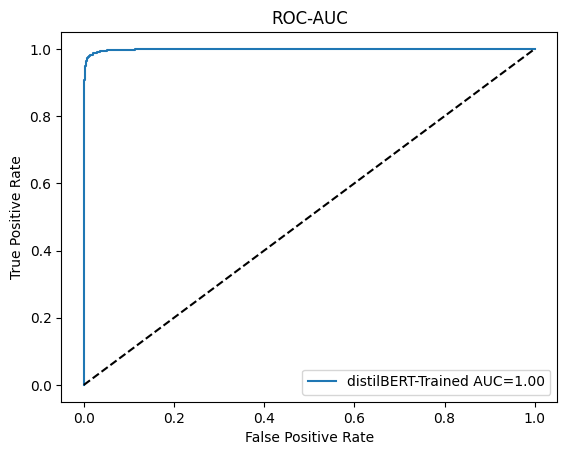

In [ ]:
plot_roc_auc_curve([row[1] for row in trained_text_results], ytest_text, text_results)

In [ ]:
plot_pre_rec_curve([row[1] for row in base_text_results], ytest_text, text_results)

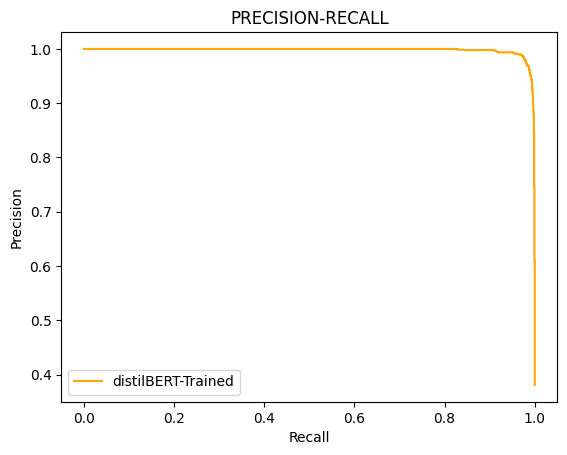

In [ ]:
plot_pre_rec_curve([row[1] for row in trained_text_results], ytest_text, text_results)